## Deep Learning Study
#### Assignment 2: MNIST 분류 모델 학습
![image](https://user-images.githubusercontent.com/44901828/228213023-6af17f20-0457-40a3-91c4-3f80bd64c1ed.png)
- Pytorch에서 제공하는 nn.Module 클래스를 활용하여 간단한 딥 러닝 모델을 설계하고, [MNIST data](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4)를 분류할 수 있도록 학습시켜 봅시다.
- MNIST 분류 문제를 잘 푸는 모델은 input으로 손으로 쓴 숫자 이미지 데이터를 받아 output으로 실제 숫자를 정확하게 예측하는 모델이라고 할 수 있습니다.

In [ ]:
import random
import numpy as np
import torchvision

# 재현을 위해 seed 고정
random.seed(42)
np.random.seed(42)

# MNIST
train_dataset = torchvision.datasets.MNIST(root="./data", transform=torchvision.transforms.ToTensor(), train=True, download=True)

- 불러온 MNIST 데이터셋이 어떤 형태로 구성되어 있는지 확인해 보겠습니다.
- 각각의 데이터는 28x28 크기의 이미지와 숫자 라벨로 구성되어 있네요.

In [ ]:
from torchvision.transforms.functional import to_pil_image

print("Total data:", len(train_dataset))
for i in range(5):
    image = train_dataset[i][0]
    label = train_dataset[i][1]
    print(f"\n[Image] {image.shape}")
    to_pil_image(image).show()
    print(f"[Label] {label}")

Total data: 60000

[Image] torch.Size([1, 28, 28])


[Label] 5

[Image] torch.Size([1, 28, 28])


[Label] 0

[Image] torch.Size([1, 28, 28])


[Label] 4

[Image] torch.Size([1, 28, 28])


[Label] 1

[Image] torch.Size([1, 28, 28])


[Label] 9


![image](https://user-images.githubusercontent.com/44901828/228216655-d792374d-a3f7-4de6-b0e9-efc106f55064.png)
- 이제 MNIST 데이터 분류를 학습할 모델을 정의해 보겠습니다.
- 이미지는 가로 28픽셀, 세로 28픽셀의 크기를 가지므로 input으로 길이 784(28*28)를 받아 output으로 10개의 라벨에 대한 확률을 출력할 수 있도록 네트워크를 구성했습니다.

In [ ]:
import torch
from torch import nn

model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    #nn.Linear(128, 64),
    #nn.ReLU(),
    nn.Linear(128, 10)
)

- 분류 문제에 일반적으로 사용되는 Cross Entropy Loss를 불러와 사용하겠습니다.
- 그리고 한번에 60,000개의 데이터를 모두 학습할 수 없기 때문에, 일정 batch 단위로 잘라서 학습할 수 있도록 해주는 DataLoader를 사용하도록 하겠습니다.

In [ ]:
loss_function = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)

- 위에서 준비한 dataloader, 모델, loss를 이용하여 학습을 진행합니다.
- Forward/backward pass를 여러번 반복하며 loss가 작아지도록 gradient descent와 back propagation을 수행하는 과정은 torch를 이용하여 간단하게 수행 가능합니다.
- Optimizer는 [Adam](https://gaussian37.github.io/dl-dlai-Adam/)을 사용했습니다.

In [ ]:
def train(model, dataloader):
  num_epochs = 10
  loss_per_step = []

  model.to('cuda')

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 100, 1, 28, 28
        # 100, 724
        images = images.reshape(-1,28*28).to('cuda')
        
        # Forward pass
        outputs = model(images)

        # Loss 계산 및 저장
        labels.to('cuda')
        loss = loss_function(outputs, labels)
        loss_per_step.append(loss.item())
        
        # Backward pass    
        # 계산된 gradient를 활용하여 파라미터 업데이트
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    print(f"epoch {epoch+1}/{num_epochs}, loss = {loss.item():.4f}")
      
  return loss_per_step

- 모델이 input data x, y를 학습하며 100step 마다 loss와 accuracy값을 저장한 뒤 시각화해서 살펴보겠습니다.
- 1개의 layer를 사용한 네트워크의 경우 학습 과정에서 loss와 accuracy가 일정 수준 이상으로 개선되지 않는 것을 볼 수 있습니다. 왜 학습이 잘 되지 않을까요?

<ipython-input-5-96b66f6aa206>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to('cuda')


epoch 1/10, loss = 1.9016
epoch 2/10, loss = 1.4320
epoch 3/10, loss = 1.0384
epoch 4/10, loss = 0.8047
epoch 5/10, loss = 0.6884
epoch 6/10, loss = 0.5686
epoch 7/10, loss = 0.5152
epoch 8/10, loss = 0.4408
epoch 9/10, loss = 0.4222
epoch 10/10, loss = 0.3882


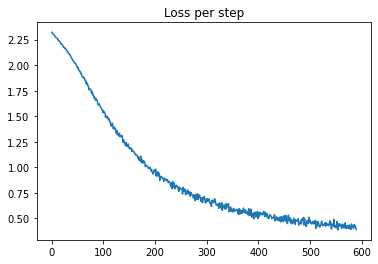

In [ ]:
from matplotlib import pyplot as plt

loss_per_step = train(model, train_loader)

plt.plot(loss_per_step)
plt.title("Loss per step")
plt.show()